# Compute Local Ensemble Mean of CMIP6 Projections

This notebook demonstrates the creation of an ensemble mean of CMIP6 ScenarioMIP models available in the Google Cloud.  This Notebook is licensed for free and open consumption under the [Attribution-NonCommercial 4.0 International (CC BY-NC 4.0)](https://creativecommons.org/licenses/by-nc/4.0/) license, Dr. T. Brikowski, U. Texas-Dallas Mar. 2025

CVS: $Id: CMIP6ensembleMean.ipynb,v 25.7 2025/04/01 16:16:17 brikowi Exp $

# Load needed packages

Be sure they have been installed using "conda install -c conda-forge packagename".

In [2]:
import zarr
import numcodecs
import numpy as np
print("Zarr version:", zarr.__version__)
print("Numcodecs version:", numcodecs.__version__)
print("Numpy version:", np.__version__)


Zarr version: 2.13.6
Numcodecs version: 0.11.0
Numpy version: 1.24.3


In [3]:
!pip install matplotlib 

In [4]:
import matplotlib.pyplot as plt
%matplotlib inline


In [5]:
!pip install xarray


In [6]:
!pip install gcsfs cftime


In [7]:
import glob
import matplotlib.pyplot as plt
import urllib.request
import numpy as np
import xarray as xr
import zarr

import pandas as pd
from difflib import get_close_matches
import gcsfs
import datetime                                   # Pandas date/time manipulation routines
import cftime                                     # NetCDF time manipulation routines
import os

# Plots open within notebook
%matplotlib inline

# Get list of desired models for processing
Get file list from Google via the given URL, use Pandas (pd) to read the CSV file and save in a *dataframe* "df".  A Pandas dataframe is like a spreadsheet format for Python with named columns.  A slightly different approach for climate model result downloads can be explored at PanGeo [intake-esm](https://intake-esm.readthedocs.io/en/stable/tutorials/loading-cmip6-data.html).  That method requires zarr version <3.0, and so is not used for this class.

In [8]:
%%time
df = pd.read_csv('https://storage.googleapis.com/cmip6/cmip6-zarr-consolidated-stores.csv')

CPU times: total: 3.23 s
Wall time: 4.23 s


## Get list of all available SSP5 8.5 models with *tasmax*
Find lines in the file-list dataframe "df" that meet the given criteria, most important are that the variable *tasmax* is in the file and that it is from a model of experiment *ssp585* (the worst-case scenario emissions/warming).

In [9]:
df_ssp585 = df.query("activity_id=='ScenarioMIP' & table_id == 'Amon' & " +\
    "variable_id == 'tasmax' & experiment_id == 'ssp585' & member_id == 'r1i1p1f1'")
print(len(df_ssp585), 'forecast files match the search criteria, the first 3 are:')
df_ssp585.head(3)

23 forecast files match the search criteria, the first 3 are:


,activity_id,institution_id,source_id,experiment_id,member_id,table_id,variable_id,grid_label,zstore,dcpp_init_year,version
888,ScenarioMIP,NOAA-GFDL,GFDL-CM4,ssp585,r1i1p1f1,Amon,tasmax,gr1,gs://cmip6/CMIP6/ScenarioMIP/NOAA-GFDL/GFDL-CM...,NaN,20180701
19009,ScenarioMIP,NOAA-GFDL,GFDL-ESM4,ssp585,r1i1p1f1,Amon,tasmax,gr1,gs://cmip6/CMIP6/ScenarioMIP/NOAA-GFDL/GFDL-ES...,NaN,20180701
66590,ScenarioMIP,BCC,BCC-CSM2-MR,ssp585,r1i1p1f1,Amon,tasmax,gn,gs://cmip6/CMIP6/ScenarioMIP/BCC/BCC-CSM2-MR/s...,NaN,20190314


## Get list of all historical models with *tasmax*

In [10]:
df_historical = df.query("activity_id == 'CMIP' & table_id == 'Amon' & " +\
    "variable_id == 'tasmax' & experiment_id == 'historical' & member_id == 'r1i1p1f1'")
print(len(df_historical), 'historical files match the search criteria, the first 3 are:')
df_historical.head(3)

32 historical files match the search criteria, the first 3 are:


,activity_id,institution_id,source_id,experiment_id,member_id,table_id,variable_id,grid_label,zstore,dcpp_init_year,version
9872,CMIP,NOAA-GFDL,GFDL-CM4,historical,r1i1p1f1,Amon,tasmax,gr1,gs://cmip6/CMIP6/CMIP/NOAA-GFDL/GFDL-CM4/histo...,NaN,20180701
29232,CMIP,IPSL,IPSL-CM6A-LR,historical,r1i1p1f1,Amon,tasmax,gr,gs://cmip6/CMIP6/CMIP/IPSL/IPSL-CM6A-LR/histor...,NaN,20180803
32350,CMIP,NASA-GISS,GISS-E2-1-G,historical,r1i1p1f1,Amon,tasmax,gn,gs://cmip6/CMIP6/CMIP/NASA-GISS/GISS-E2-1-G/hi...,NaN,20180827


## Make list of models with BOTH historical and future tasmax and pr
See <a href="https://stackoverflow.com/questions/55898796/how-to-match-keys-of-2-data-frames-and-create-new-df-with-matching-keys">StackOverflow</a> for suggestions.  Current code requires start with shortest dataframe (!).

In [11]:
seq = [r for r in df_ssp585["source_id"] if get_close_matches(r, df_historical["source_id"], n=1, cutoff = .85)]
bothSources = np.unique(np.array(seq))
print(len(bothSources), "models have both historical and SSP5-8.5 results, e.g. ", bothSources[3])

gcs = gcsfs.GCSFileSystem(token='anon')


21 models have both historical and SSP5-8.5 results, e.g.  CIESM


In [12]:
for i in range(len(bothSources)):
    # model = 'GFDL-CM4'
    print("Model name: ", bothSources[i])


Model name:  ACCESS-CM2
Model name:  AWI-CM-1-1-MR
Model name:  BCC-CSM2-MR
Model name:  CIESM
Model name:  CanESM5
Model name:  EC-Earth3
Model name:  EC-Earth3-Veg
Model name:  EC-Earth3-Veg-LR
Model name:  FGOALS-g3
Model name:  FIO-ESM-2-0
Model name:  GFDL-CM4
Model name:  GFDL-ESM4
Model name:  INM-CM4-8
Model name:  INM-CM5-0
Model name:  IPSL-CM6A-LR
Model name:  KACE-1-0-G
Model name:  MIROC6
Model name:  MPI-ESM1-2-HR
Model name:  MPI-ESM1-2-LR
Model name:  MRI-ESM2-0
Model name:  NESM3


## Define functions to get desired variable from desired model

In [13]:
def getVar(modelList, modelName):
    import gcsfs
    fs = gcsfs.GCSFileSystem(token='anon')  # Force anonymous access
    zstore = modelList.query(f"source_id == '{modelName}'").zstore.values[0]
    mapper = fs.get_mapper(zstore)
    ds = xr.open_zarr(mapper, consolidated=True)
    ds.load()
    return ds


In [14]:
# Define lat-long box for New York area (includes NYC + surrounding)
left = 360 - 75.0    # longitude west is converted to 360 format
right = 360 - 73.0
bottom = 40.0
top = 42.0
locName = 'NewYork'


# Get historical model statistics

Accumulate ensemble mean and confidence bands.

Author's note: consider filtering for NaN results if lat-long box is narrower than some model grid spacing

In [15]:
%%time
filename = "historical_tasmax.csv"

for i in range(len(bothSources)):
    model = bothSources[i]
    print("Processing model: %s" % (model), end='...')

    ds_hist = getVar(df_historical, model)

    localHist = ds_hist.isel(
        lat=(ds_hist.lat >= bottom) & (ds_hist.lat <= top),
        lon=(ds_hist.lon >= left) & (ds_hist.lon <= right)
    ).mean(['lat', 'lon']).drop_vars(['height'])

    # Supports both cftime and datetime64
    years = [t.year if hasattr(t, 'year') else pd.to_datetime(t).year for t in localHist.time.values]
    hist4export = (localHist.tasmax.groupby(xr.DataArray(years, dims="time")).mean() - 273.15)

    tempDF = hist4export.to_dataframe()

    if i == 0:
        histTASmax = tempDF
        histTASmax.columns = [model]
    else:
        tempDF2 = pd.concat([histTASmax, tempDF["tasmax"]], axis=1).reindex(histTASmax.index)
        tempDF2.rename(columns={tempDF2.columns[-1]: model}, inplace=True)
        histTASmax = tempDF2


Processing model: ACCESS-CM2...Processing model: AWI-CM-1-1-MR...Processing model: BCC-CSM2-MR...Processing model: CIESM...Processing model: CanESM5...Processing model: EC-Earth3...Processing model: EC-Earth3-Veg...Processing model: EC-Earth3-Veg-LR...Processing model: FGOALS-g3...Processing model: FIO-ESM-2-0...Processing model: GFDL-CM4...Processing model: GFDL-ESM4...Processing model: INM-CM4-8...Processing model: INM-CM5-0...Processing model: IPSL-CM6A-LR...Processing model: KACE-1-0-G...Processing model: MIROC6...Processing model: MPI-ESM1-2-HR...Processing model: MPI-ESM1-2-LR...Processing model: MRI-ESM2-0...Processing model: NESM3...CPU times: total: 1min 1s
Wall time: 1min 51s


# Repeat for projected TASmax

In [16]:
%%time
filename = "ssp585_tasmax.csv"

for i in range(len(bothSources)):
    model = bothSources[i]
    print("Processing model: %s" % (model), end='...')

    ds_proj = getVar(df_ssp585, model)

    localProj = ds_proj.isel(
        lat=(ds_proj.lat >= bottom) & (ds_proj.lat <= top),
        lon=(ds_proj.lon >= left) & (ds_proj.lon <= right)
    ).mean(['lat', 'lon']).drop_vars(['height'])

    years = [t.year if hasattr(t, 'year') else pd.to_datetime(t).year for t in localProj.time.values]
    proj4export = (localProj.tasmax.groupby(xr.DataArray(years, dims="time")).mean() - 273.15)

    tempDF = proj4export.to_dataframe()

    if i == 0:
        projTASmax = tempDF
        projTASmax.columns = [model]
    else:
        tempDF2 = pd.concat([projTASmax, tempDF["tasmax"]], axis=1).reindex(projTASmax.index)
        tempDF2.rename(columns={tempDF2.columns[-1]: model}, inplace=True)
        projTASmax = tempDF2


Processing model: ACCESS-CM2...Processing model: AWI-CM-1-1-MR...Processing model: BCC-CSM2-MR...Processing model: CIESM...Processing model: CanESM5...

C:\Users\gargi\AppData\Local\Temp\ipykernel_21028\2678097262.py:6: SerializationWarning: Unable to decode time axis into full numpy.datetime64[ns] objects, continuing using cftime.datetime objects instead, reason: dates out of range. To silence this warning use a coarser resolution 'time_unit' or specify 'use_cftime=True'.
  ds = xr.open_zarr(mapper, consolidated=True)
C:\Users\gargi\AppData\Local\Temp\ipykernel_21028\2678097262.py:7: SerializationWarning: Unable to decode time axis into full numpy.datetime64[ns] objects, continuing using cftime.datetime objects instead, reason: dates out of range. To silence this warning use a coarser resolution 'time_unit' or specify 'use_cftime=True'.
  ds.load()


Processing model: EC-Earth3...Processing model: EC-Earth3-Veg...Processing model: EC-Earth3-Veg-LR...Processing model: FGOALS-g3...Processing model: FIO-ESM-2-0...Processing model: GFDL-CM4...Processing model: GFDL-ESM4...Processing model: INM-CM4-8...Processing model: INM-CM5-0...Processing model: IPSL-CM6A-LR...Processing model: KACE-1-0-G...Processing model: MIROC6...Processing model: MPI-ESM1-2-HR...Processing model: MPI-ESM1-2-LR...Processing model: MRI-ESM2-0...Processing model: NESM3...CPU times: total: 32.5 s
Wall time: 1min 9s


# Generate and Plot Local All-Avaliable-Model Ensemble Mean-Median-Confidence Intervals

Again note that models coarser than the specified local lat-long box will yield 'NaN' (not a number) values.  These are ignored by matplotlib, but may confuse other plotting tools like Excel.

In [17]:
projAvg = projTASmax.mean(axis=1)
histAvg = histTASmax.mean(axis=1)

## Plot all models and mean

Text(0.5, 1.02, 'TASmax From All Available CMIP6 Models NewYork Area')

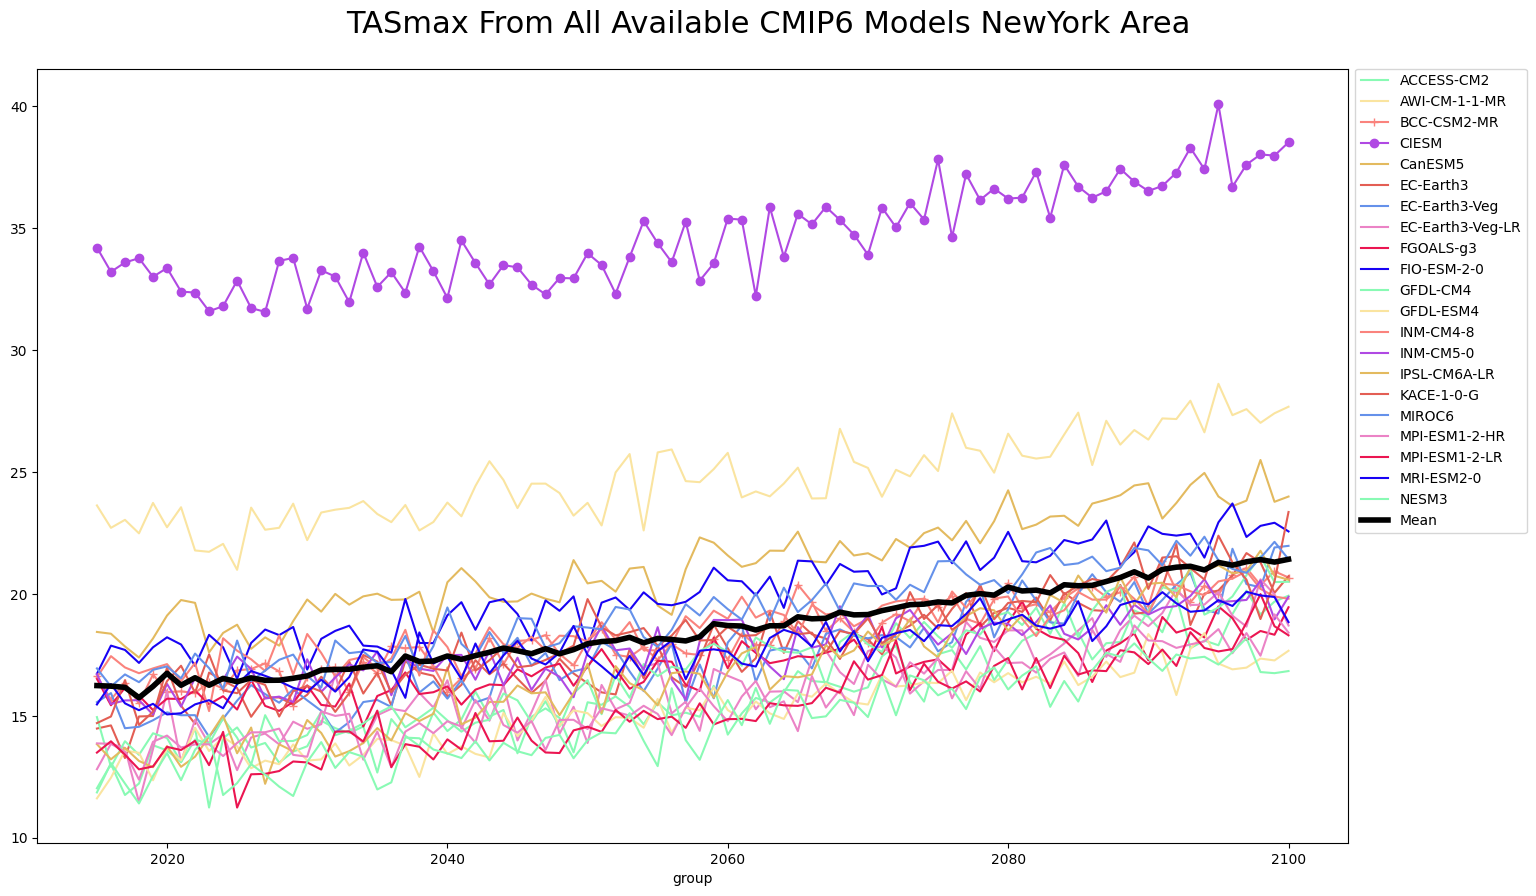

In [18]:
colors = ['#89FAB4', '#FAE4A0', '#FA837D', '#B049E3', '#E3BA5F', '#E35E54', '#6591EA', '#EB83C6', '#EB1551', '#1802F4']
styles = ['', '', '-+', '-o', '', '', '', '', '', '']

ax = projTASmax.plot(style=styles, color=colors, figsize=(16, 9))  # plot the dataframe and set Time as x
projAvg.plot(label='Mean', color='black', linewidth=4)
ax.legend(bbox_to_anchor=(1, 1.01), loc='upper left') # move the legend
fig = ax.get_figure()  # extract the figure object
fig.tight_layout(pad=3)
fig.suptitle(f'TASmax From All Available CMIP6 Models {locName} Area', fontsize=22, y=1.02, color='black')


In [19]:
# Compute quantiles, append to dataframe
histTASmax["Mean"] = histAvg
histTASmax["Q05"] = histTASmax.quantile(.05, axis=1)
histTASmax["Q25"] = histTASmax.quantile(.25, axis=1)
histTASmax["Q50"] = histTASmax.quantile(.50, axis=1)       # Median not mean !
histTASmax["Q75"] = histTASmax.quantile(.75, axis=1)
histTASmax["Q95"] = histTASmax.quantile(.95, axis=1)

# Save final results to file (alert Python programmers could just plot the dataframe histTASmax..)
filename = f'allCMIP6historicalTASmax_{locName}.csv'
histTASmax.to_csv(filename)
print("\nSaved local historic TASmax to file: ", filename)

# Compute quantiles, append to dataframe
projTASmax["Mean"] = projAvg
projTASmax["Q05"] = projTASmax.quantile(.05, axis=1)
projTASmax["Q25"] = projTASmax.quantile(.25, axis=1)
projTASmax["Q50"] = projTASmax.quantile(.50, axis=1)
projTASmax["Q75"] = projTASmax.quantile(.75, axis=1)
projTASmax["Q95"] = projTASmax.quantile(.95, axis=1)

# Save final results to file (alert Python programmers could just plot the dataframe projTASmax..)
filename = f'allCMIP6projTASmax_{locName}.csv'
projTASmax.to_csv(filename)
print("\nSaved local projected TASmax to file: ", filename)
projTASmax.head(5)


Saved local historic TASmax to file:  allCMIP6historicalTASmax_NewYork.csv

Saved local projected TASmax to file:  allCMIP6projTASmax_NewYork.csv


,ACCESS-CM2,AWI-CM-1-1-MR,BCC-CSM2-MR,CIESM,CanESM5,EC-Earth3,EC-Earth3-Veg,EC-Earth3-Veg-LR,FGOALS-g3,FIO-ESM-2-0,...,MPI-ESM1-2-HR,MPI-ESM1-2-LR,MRI-ESM2-0,NESM3,Mean,Q05,Q25,Q50,Q75,Q95
group,,,,,,,,,,,,,,,,,,,,,
2015,12.023804,23.623444,16.608734,34.200806,18.434509,14.472778,15.554199,12.804993,16.514801,16.715454,...,13.863892,13.485962,15.460449,11.852112,16.234070,11.860696,13.658722,15.200989,16.608734,22.326210
2016,13.015686,22.703735,15.662567,33.203796,18.361664,14.601746,15.926941,13.847137,15.427002,17.873383,...,13.847809,13.949341,16.296204,13.053833,16.210720,12.909229,13.528809,15.196503,16.210720,21.618217
2017,11.746704,23.032196,16.348602,33.587616,17.840027,13.262329,14.485535,13.675568,16.143127,17.697662,...,13.519684,13.399536,15.505951,12.218018,16.162796,12.270233,13.545593,14.995743,16.455566,21.734154
2018,12.217377,22.478302,15.501404,33.763000,17.384369,14.967651,14.544342,11.449402,15.822601,17.164246,...,12.377075,12.798828,15.224304,11.400085,15.737147,11.487801,12.970840,14.795151,15.822601,21.204819
2019,13.788483,23.726410,16.690521,33.000885,18.166809,14.987305,14.812439,13.631287,15.228973,17.804504,...,13.929321,12.918335,15.486267,12.529755,16.202105,12.547650,13.709885,15.016190,16.690521,22.336510


## Plot all-model mean-median & confidence intervals

# Explore Mahoney-Wang-2022 Ensemble Local Mean

[Mahoney, et al., 2022](https://dx.doi.org/10.1002/joc.7566) define 13 and 8 model ensembles drawn from 45 available CMIP6 models (in 2020).   These are claimed to be superior for North America, and especially for specialized downscaling approaches. 

In [20]:
# Define list of model names in the two ensembles
mahoneyWang13 = ['ACCESS-ESM1.5', 'BCC-CSM2', 'CanESM5', 'CNRM-ESM2-1', 'EC-Earth3', 'GFDL-ESM4', 'GISS-E2-1', 'INM-CM5-0', 
                 'IPSL-CM6A-LR', 'MIROC6', 'MPI-ESM1-2-HR', 'MRI-ESM2-0', 'UKESM1']
mahoneyWang8 = ['ACCESS-ESM1-5', 'CNRM-ESM2-1', 'EC-Earth3', 'GFDL-ESM4', 'GISS-E2-1-H', 'MIROC6', 'MPI-ESM1-2-HR', 'MRI-ESM2-0']
# Limit to Mahoney-Wang ensembles that have both historical ans SSP585 projection results at Google
mahoneyBoth = []
for i in range(len(mahoneyWang13)):
    if get_close_matches(mahoneyWang13[i],bothSources, n=1, cutoff = .85):
        mahoneyBoth.append(mahoneyWang13[i])
    else:
       print(f'\n\tModel {mahoneyWang13[i]}: unable to find historical and SSP585 results in Google CMIP6 list.')

print(f'{len(mahoneyBoth)} out of {len(mahoneyWang13)} historical+SSP585 models available for ensemble calculations')


	Model ACCESS-ESM1.5: unable to find historical and SSP585 results in Google CMIP6 list.

	Model BCC-CSM2: unable to find historical and SSP585 results in Google CMIP6 list.

	Model CNRM-ESM2-1: unable to find historical and SSP585 results in Google CMIP6 list.

	Model GISS-E2-1: unable to find historical and SSP585 results in Google CMIP6 list.

	Model UKESM1: unable to find historical and SSP585 results in Google CMIP6 list.
8 out of 13 historical+SSP585 models available for ensemble calculations


In [21]:
%%time
colNum = 0
for i in range(len(mahoneyBoth)):
    model = mahoneyBoth[i]
    print(f'Processing model {model}', end='...')
    mh_hist = getVar(df_historical, model)
    localHist = mh_hist.isel(lat = (mh_hist.lat>=bottom) & (mh_hist.lat<=top), lon = (mh_hist.lon>=left) 
                            & (mh_hist.lon<=right)).mean(['lat','lon']).drop_vars(['height'])
    hist4export = (localHist.groupby('time.year').mean().tasmax-273.15)
    tempDF = hist4export.to_dataframe()
    # Append results to dataframe
    if i==0:
        mhhistTASmax = tempDF
        mhhistTASmax.columns = [model]
    else:
        tempDF2 = pd.concat([mhhistTASmax, tempDF["tasmax"]], axis=1).reindex(mhhistTASmax.index)
        tempDF2.rename(columns={tempDF2.columns[colNum]:model}, inplace=True)
        mhhistTASmax = tempDF2
    colNum += 1

mhhistTASmax

Processing model CanESM5...Processing model EC-Earth3...Processing model GFDL-ESM4...Processing model INM-CM5-0...Processing model IPSL-CM6A-LR...Processing model MIROC6...Processing model MPI-ESM1-2-HR...Processing model MRI-ESM2-0...CPU times: total: 25.1 s
Wall time: 38.1 s


,CanESM5,EC-Earth3,GFDL-ESM4,INM-CM5-0,IPSL-CM6A-LR,MIROC6,MPI-ESM1-2-HR,MRI-ESM2-0
year,,,,,,,,
1850,15.660645,12.358032,12.734558,14.724060,12.227661,15.523499,13.332825,13.925537
1851,17.545197,13.756317,12.631531,15.571167,13.533203,15.716125,12.822174,13.658508
1852,16.327209,14.754547,11.614868,14.614807,11.210724,16.394531,12.340302,13.842041
1853,15.070923,13.010956,11.907349,15.713196,11.436401,16.460968,12.321930,14.803650
1854,17.614563,12.573578,12.040222,15.255737,11.363495,16.091858,11.475464,14.968262
...,...,...,...,...,...,...,...,...
2010,16.852600,14.677246,12.797485,16.333038,15.079895,17.244720,13.199524,14.179688
2011,17.135590,14.985504,13.232300,16.055450,13.677734,16.709106,12.531464,15.039429
2012,18.354279,15.349640,12.416290,15.063538,13.015991,15.560455,13.163818,13.931519


In [22]:
%%time

# Repeat for future
maxTime = cftime.DatetimeNoLeap(2099, 12, 31, 23, 59, 59, 0, has_year_zero=True)   # Clip CanESMS model to 21st century
colNum = 0
for i in range(len(mahoneyBoth)):
    model = mahoneyBoth[i]
    print(f'Processing model {model}', end='...')
    mh_proj = getVar(df_ssp585, model)
    localProj = mh_proj.isel(lat = (mh_proj.lat>=bottom) & (mh_proj.lat<=top), lon = (mh_proj.lon>=left) 
                            & (mh_proj.lon<=right)).mean(['lat','lon']).drop_vars(['height'])
    proj4export = (localProj.groupby('time.year').mean().tasmax-273.15)
    tempDF = proj4export.to_dataframe()
    # Append results to dataframe
    if colNum==0:
        mhprojTASmax = tempDF
        mhprojTASmax.columns = [model]
    else:
        tempDF2 = pd.concat([mhprojTASmax, tempDF["tasmax"]], axis=1).reindex(mhprojTASmax.index)
        tempDF2.rename(columns={tempDF2.columns[colNum]:model}, inplace=True)
        mhprojTASmax = tempDF2
    colNum += 1        

mhprojMeanTASmax = mhprojTASmax[:2100]                    # Clip array to 21st century (fix error in CanESMS...)


Processing model CanESM5...

C:\Users\gargi\AppData\Local\Temp\ipykernel_21028\2678097262.py:6: SerializationWarning: Unable to decode time axis into full numpy.datetime64[ns] objects, continuing using cftime.datetime objects instead, reason: dates out of range. To silence this warning use a coarser resolution 'time_unit' or specify 'use_cftime=True'.
  ds = xr.open_zarr(mapper, consolidated=True)
C:\Users\gargi\AppData\Local\Temp\ipykernel_21028\2678097262.py:7: SerializationWarning: Unable to decode time axis into full numpy.datetime64[ns] objects, continuing using cftime.datetime objects instead, reason: dates out of range. To silence this warning use a coarser resolution 'time_unit' or specify 'use_cftime=True'.
  ds.load()


Processing model EC-Earth3...Processing model GFDL-ESM4...Processing model INM-CM5-0...Processing model IPSL-CM6A-LR...Processing model MIROC6...Processing model MPI-ESM1-2-HR...Processing model MRI-ESM2-0...CPU times: total: 13.3 s
Wall time: 26.3 s


## Export ensemble means

Calculate and include 50 & 95% confidence intervals.  Save to CSV file.

In [23]:
filename = f'CMPI6historicalEnsembleMeanTASmax_{locName}.csv'
mhhistTASmax["Q05"] = mhhistTASmax.quantile(.05, axis=1)
mhhistTASmax["Q25"] = mhhistTASmax.quantile(.25, axis=1)
mhhistTASmax["Q50"] = mhhistTASmax.quantile(.50, axis=1)
mhhistTASmax["Q75"] = mhhistTASmax.quantile(.75, axis=1)
mhhistTASmax["Q95"] = mhhistTASmax.quantile(.95, axis=1)
mhhistTASmax["Mean"] = mhhistTASmax.mean(axis=1)
mhhistTASmax.to_csv(filename)
print("\nSaved local projected TASmax to file: ", filename)

filename = f'ssp585ensembleMeanTASmax_{locName}.csv'
mhprojTASmax["Q05"] = mhprojTASmax.quantile(.05, axis=1)
mhprojTASmax["Q25"] = mhprojTASmax.quantile(.25, axis=1)
mhprojTASmax["Q50"] = mhprojTASmax.quantile(.50, axis=1)
mhprojTASmax["Q75"] = mhprojTASmax.quantile(.75, axis=1)
mhprojTASmax["Q95"] = mhprojTASmax.quantile(.95, axis=1)
mhprojTASmax["Mean"] = mhprojTASmax.mean(axis=1)
mhprojTASmax.to_csv(filename)
mhprojTASmax.head(5)


Saved local projected TASmax to file:  CMPI6historicalEnsembleMeanTASmax_NewYork.csv


,CanESM5,EC-Earth3,GFDL-ESM4,INM-CM5-0,IPSL-CM6A-LR,MIROC6,MPI-ESM1-2-HR,MRI-ESM2-0,Q05,Q25,Q50,Q75,Q95,Mean
year,,,,,,,,,,,,,,
2015,18.434509,14.472778,11.608582,16.704529,13.831482,16.940399,13.863892,15.460449,12.386597,13.831482,14.168335,16.082489,17.612749,15.030636
2016,18.361664,14.601746,12.454620,15.479797,13.210480,16.197906,13.847809,16.296204,12.719172,13.210480,14.224777,15.838852,17.225660,14.897629
2017,17.840027,13.262329,13.571503,15.625000,13.680176,16.692444,13.519684,15.505951,13.352404,13.519684,13.625839,15.565475,17.208857,14.843798
2018,17.384369,14.967651,13.474670,15.637329,13.142853,16.374146,12.377075,15.224304,12.645098,13.142853,14.221161,15.430817,16.828747,14.680852
2019,18.166809,14.987305,12.350006,15.045074,12.887665,16.880707,13.929321,15.486267,12.538187,12.887665,14.458313,15.265671,17.459454,14.795573


# Plot Ensemble Means & Confidence Interval

In [24]:
!pip install pandoc



  Preparing metadata (setup.py): started
  Preparing metadata (setup.py): finished with status 'done'
  Created wheel for pandoc: filename=pandoc-2.4-py3-none-any.whl size=34869 sha256=7bc6bebf023245d1231c31f174c150b826306747f5ea21b26e7347152e3ec414
  Stored in directory: c:\users\gargi\appdata\local\pip\cache\wheels\14\79\8c\5d7a023cc8df1aa0381c1739d69da18ae7f90c08b2dc9a1bf5
Successfully built pandoc
